STEP 1: Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Fracture_Project/MURA.zip'
extract_path = '/content/MURA'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("MURA dataset extracted.")

MURA dataset extracted.


STEP 2: Import Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

STEP 3: Load CSVs and Explore Labels

In [4]:
BASE_PATH = '/content/MURA/MURA-v1.1'

# Load CSVs
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train_labeled_studies.csv'), header=None)
valid_df = pd.read_csv(os.path.join(BASE_PATH, 'valid_labeled_studies.csv'), header=None)

train_df.columns = ['path', 'label']
valid_df.columns = ['path', 'label']

# Convert to int
train_df['label'] = train_df['label'].astype(int)
valid_df['label'] = valid_df['label'].astype(int)

# Preview
train_df.head()


,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


 STEP 4: Exploratory Data Analysis (EDA)

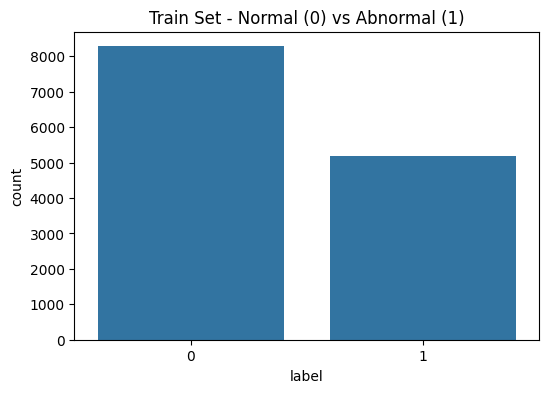

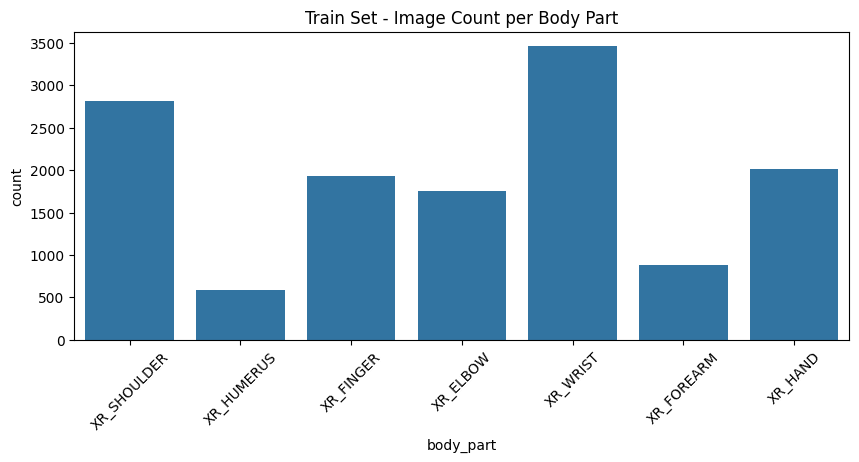

In [5]:
# Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df)
plt.title("Train Set - Normal (0) vs Abnormal (1)")
plt.show()

# Distribution by body part
train_df['body_part'] = train_df['path'].apply(lambda x: x.split('/')[2])
plt.figure(figsize=(10,4))
sns.countplot(x='body_part', data=train_df)
plt.title("Train Set - Image Count per Body Part")
plt.xticks(rotation=45)
plt.show()


 STEP 5: Convert Paths to Full Image Files

In [6]:
import glob

# Collect image paths and labels
image_paths = []
labels = []

for i, row in train_df.iterrows():
    study_path = os.path.join('/content/MURA', row['path'])  # NOTE: Adjusted path
    for img_file in glob.glob(study_path + '/*.png'):
        image_paths.append(img_file)
        labels.append(row['label'])

val_image_paths = []
val_labels = []

for i, row in valid_df.iterrows():
    study_path = os.path.join('/content/MURA', row['path'])
    for img_file in glob.glob(study_path + '/*.png'):
        val_image_paths.append(img_file)
        val_labels.append(row['label'])

print("✅ Total training images:", len(image_paths))
print("✅ Total validation images:", len(val_image_paths))


✅ Total training images: 36808
✅ Total validation images: 3197


STEP 6: Prepare TensorFlow Datasets

In [7]:
paths_tensor = tf.constant(image_paths)
labels_tensor = tf.constant(labels)

val_paths_tensor = tf.constant(val_image_paths)
val_labels_tensor = tf.constant(val_labels)

def load_rgb_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32)
    return img, label

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess(img, label):
    return preprocess_input(img), label

# Apply map functions
train_dataset_rgb = tf.data.Dataset.from_tensor_slices((paths_tensor, labels_tensor))
train_dataset_rgb = train_dataset_rgb.map(load_rgb_image).map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_rgb = tf.data.Dataset.from_tensor_slices((val_paths_tensor, val_labels_tensor))
val_dataset_rgb = val_dataset_rgb.map(load_rgb_image).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


STEP 6: Create ResNet50 Model

In [8]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

STEP 7: Train

In [9]:
history = model.fit(train_dataset_rgb, validation_data=val_dataset_rgb, epochs=15)

Epoch 1/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 249s 200ms/step - accuracy: 0.8771 - loss: 0.3189 - val_accuracy: 0.5214 - val_loss: 1.8194
Epoch 2/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.8380 - loss: 0.4170 - val_accuracy: 0.5239 - val_loss: 1.7270
Epoch 3/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.8339 - loss: 0.4247 - val_accuracy: 0.5242 - val_loss: 1.8284
Epoch 4/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 210s 161ms/step - accuracy: 0.8341 - loss: 0.4210 - val_accuracy: 0.5271 - val_loss: 1.6694
Epoch 5/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 195s 156ms/step - accuracy: 0.8327 - loss: 0.4092 - val_accuracy: 0.5321 - val_loss: 1.6157
Epoch 6/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 222s 173ms/step - accuracy: 0.8420 - loss: 0.4024 - val_accuracy: 0.5280 - val_loss: 1.8544
Epoch 7/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 182s 155ms/step - accuracy: 0.8430 - loss: 0.4194 - val_accuracy: 0.5308 - val_loss: 1.8767
Epoch 8/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 186s 159ms/step - ac

 STEP 8: Grad-CAM for Model Explainability

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


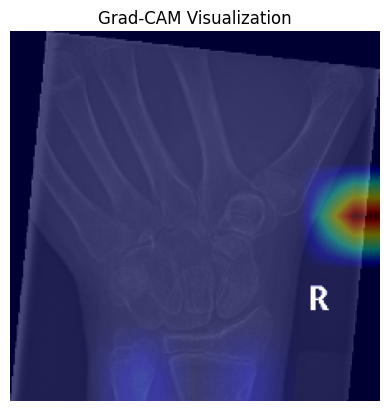

In [10]:
import cv2
import matplotlib.cm as cm

def get_img_array(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return tf.expand_dims(img, axis=0)

# Grad-CAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Visualize one sample image from validation set
sample_path = val_image_paths[0]
sample_array = get_img_array(sample_path)
heatmap = make_gradcam_heatmap(sample_array, model, 'conv5_block3_out')  # last conv layer of ResNet50

# Display Grad-CAM
img = cv2.imread(sample_path)
img = cv2.resize(img, (224, 224))
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_colored = cm.jet(heatmap_resized)[..., :3]
superimposed_img = heatmap_colored * 0.4 + img / 255.0

plt.imshow(superimposed_img)
plt.axis('off')
plt.title('Grad-CAM Visualization')
plt.savefig('gradcam_resnet50.png')


plt.show()

STEP 9: Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

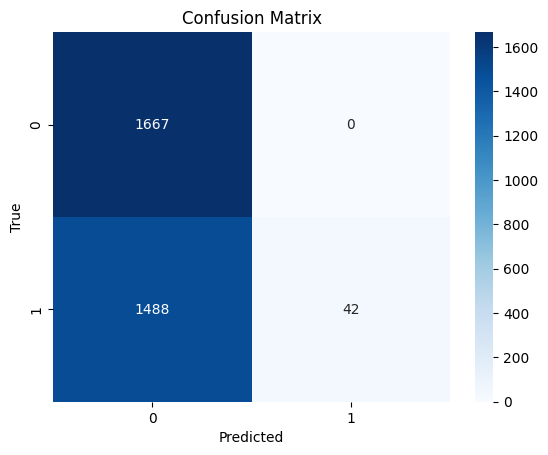

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

for img, label in val_dataset_rgb:
    preds = model.predict(img)
    y_true.extend(label.numpy())
    y_pred.extend((preds > 0.5).astype(int))

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_resnet50.png')
plt.show()